# Dfs0 - CMEMS *in-situ* data

In [7]:
import pandas as pd
import xarray as xr
import mikeio

In [3]:
fino = xr.open_dataset("../tests/testdata/NO_TS_MO_FINO1_202209.nc")
fino

<xarray.Dataset>
Dimensions:      (TIME: 2879, LATITUDE: 2879, LONGITUDE: 2879, DEPTH: 7,
                  POSITION: 2879)
Coordinates:
  * TIME         (TIME) datetime64[ns] 2022-09-01 ... 2022-09-30T23:31:59.999...
  * LATITUDE     (LATITUDE) float32 54.0 54.0 54.0 54.0 ... 54.0 54.0 54.0 54.0
  * LONGITUDE    (LONGITUDE) float32 6.583 6.583 6.583 ... 6.583 6.583 6.583
    DEPH         (TIME, DEPTH) float32 ...
Dimensions without coordinates: DEPTH, POSITION
Data variables: (12/22)
    DEPH_QC      (TIME, DEPTH) float32 ...
    TIME_QC      (TIME) float32 ...
    POSITION_QC  (POSITION) float32 ...
    TEMP         (TIME, DEPTH) float64 ...
    TEMP_QC      (TIME, DEPTH) float32 ...
    VHM0         (TIME, DEPTH) float64 ...
    ...           ...
    VTPK_DM      (TIME, DEPTH) object ...
    VTZA         (TIME, DEPTH) float64 ...
    VTZA_QC      (TIME, DEPTH) float32 ...
    VPED         (TIME, DEPTH) float64 ...
    VPED_QC      (TIME, DEPTH) float32 ...
    VPED_DM      (TIME, DEPTH) object ...
Attributes: (12/46)
    platform_code:                  FINO1
    platform_name:                  
    data_mode:                      M
    title:                          NWS - NRT in situ Observations
    summary:                        Oceanographic data from North West Shelf
    naming_authority:               Copernicus Marine In Situ
    ...                             ...
    doi:                            
    pi_name:                        
    qc_manual:                      OceanSITES User's Manual v1.2
    date_update:                    2022-10-07T05:39:40Z
    history:                        2022-10-01T18:04:25Z : Creation; 2022-10-...
    wmo_inst_type:

CMEMS *in-situ* data is provided in a standardised format, the [OceanSITES time-series data format](http://www.oceansites.org/docs/oceansites_data_format_reference_manual.pdf).

> "*The OceanSITES programme is the global network of open-ocean sustained time series 
sites, called ocean reference stations, being implemented by an international partnership of 
researchers and agencies. OceanSITES provides fixed-point time series of various physical, 
biogeochemical, ecosystem and atmospheric variables at locations around the globe, from 
the atmosphere and sea surface to the seafloor. The program’s objective is to build and 
maintain a multidisciplinary global network for a broad range of research and operational 
applications including climate, carbon, and ecosystem variability and forecasting and ocean 
state validation*"


Find out which variables we are interested in to extract:

In [25]:
pd.DataFrame([{'name': fino[var].name, 'standard_name': fino[var].standard_name, 'units': fino[var].units} for var in fino.data_vars if hasattr(fino[var],"units")])

,name,standard_name,units
0,TEMP,sea_water_temperature,degrees_C
1,VHM0,sea_surface_wave_significant_height,m
2,VZMX,sea_surface_wave_maximum_height,m
3,VTM02,sea_surface_wave_mean_period_from_variance_spe...,s
4,VTPK,sea_surface_wave_period_at_variance_spectral_d...,s
5,VTZA,sea_surface_wave_mean_period,s
6,VPED,sea_surface_wave_from_direction_at_variance_sp...,degree


The data have a DEPTH dimension, even though variables are only measured at a single level and doesn't vary in time although the format allows for it.

I.e. temperature (TEMP) is available at level 1 (0.5 m)

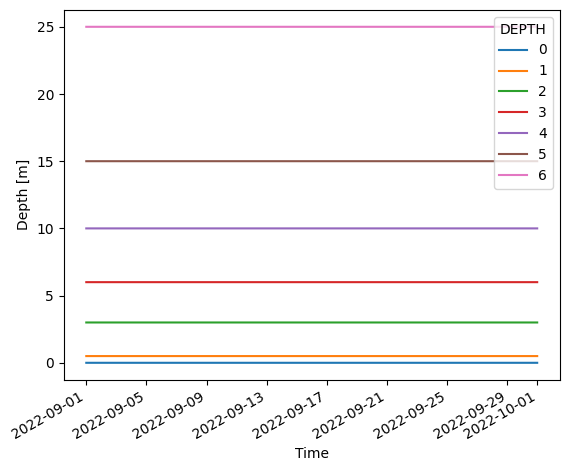

In [61]:
fino.DEPH.plot.line(x='TIME');

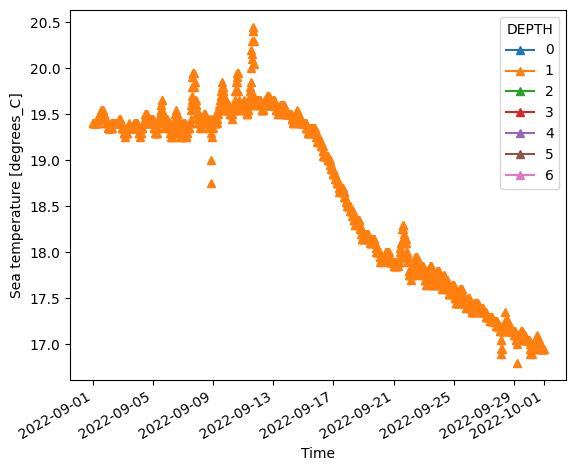

In [49]:
fino['TEMP'].plot.line("-^",x='TIME');

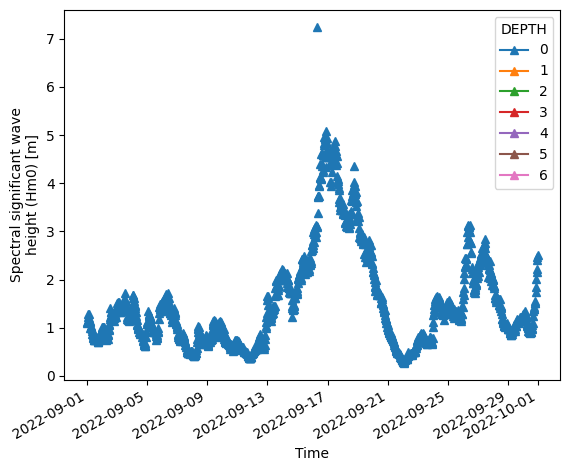

In [48]:
fino['VHM0'].plot.line("-^",x='TIME');

Wave data are only available at the surface.

In [63]:
fino[['VHM0','VTZA','VPED']].isel(DEPTH=0)

<xarray.Dataset>
Dimensions:  (TIME: 2879)
Coordinates:
  * TIME     (TIME) datetime64[ns] 2022-09-01 ... 2022-09-30T23:31:59.999999744
    DEPH     (TIME) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
Data variables:
    VHM0     (TIME) float64 nan 1.11 nan 1.09 nan ... 2.46 nan 2.41 nan 2.51
    VTZA     (TIME) float64 4.12 nan 4.18 nan 4.0 nan ... nan 5.2 nan 5.44 nan
    VPED     (TIME) float64 nan 2.8 nan 353.0 nan ... 192.7 nan 234.8 nan 244.7
Attributes: (12/46)
    platform_code:                  FINO1
    platform_name:                  
    data_mode:                      M
    title:                          NWS - NRT in situ Observations
    summary:                        Oceanographic data from North West Shelf
    naming_authority:               Copernicus Marine In Situ
    ...                             ...
    doi:                            
    pi_name:                        
    qc_manual:                      OceanSITES User's Manual v1.2
    date_update:                    2022-10-07T05:39:40Z
    history:                        2022-10-01T18:04:25Z : Creation; 2022-10-...
    wmo_inst_type:

In [64]:
df = fino[['VHM0','VTZA','VPED']].isel(DEPTH=0).to_dataframe()

The data are stored on the concurrent timesteps.

In [71]:
df[['VHM0','VTZA','VPED']].head()

,VHM0,VTZA,VPED
TIME,,,
2022-09-01 00:00:00,NaN,4.12,NaN
2022-09-01 00:02:00,1.11,NaN,2.800000
2022-09-01 00:30:00,NaN,4.18,NaN
2022-09-01 00:32:00,1.09,NaN,353.000017
2022-09-01 01:00:00,NaN,4.00,NaN


<AxesSubplot: xlabel='TIME'>

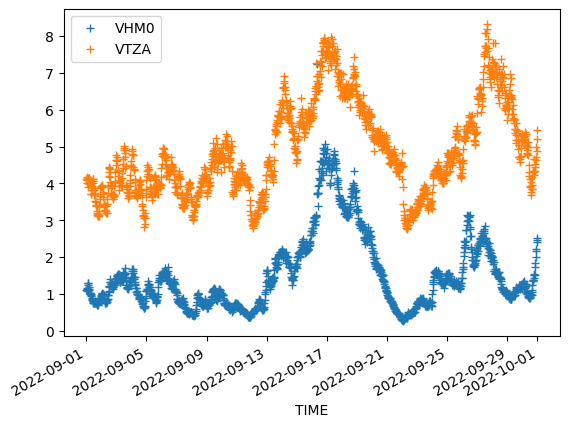

In [70]:
df[['VHM0','VTZA']].plot(style='+')

Store the results in Dfs0 format.

In [77]:
pd.Series.to_dfs0?

Signature:
pd.Series.to_dfs0(
    self,
    filename,
    itemtype=None,
    unit=None,
    items=None,
    title=None,
    dtype=None,
)
Docstring: <no docstring>
File:      ~/mambaforge/lib/python3.10/site-packages/mikeio/dfs0.py
Type:      function


In [78]:
df['VHM0'].dropna().to_dfs0("FINO1_VHM0.dfs0", itemtype=mikeio.EUMType.Significant_wave_height)

Read the file again to check...

In [80]:
ds = mikeio.read("FINO1_VHM0.dfs0")
ds

<mikeio.Dataset>
dims: (time:1439)
time: 2022-09-01 00:02:00 - 2022-09-30 23:32:00 (1439 non-equidistant records)
items:
  0:  VHM0 <Significant wave height> (meter)